In [1]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np
import sys
#
sys.path.insert(0,"/home/aschulz")
import amdapy
from amdapy.amdaWSClient.client import AMDARESTClient, get_parameter
import os
import pandas as pd
import datetime
widgets.__version__
widgets.IntSlider()

IntSlider(value=0)

In [2]:
df=get_parameter("imf",'2008-01-01T00:00:00', '2008-01-01T20:00:00',col_names=["Time","bx","by","bz"])
print("Dataset shape : {}".format(df.shape))
print(df)

in get_parameter imf
done
Dataset shape : (4500, 4)
                    Time     bx     by     bz
0    2008-01-01 00:00:08 -3.840  0.428 -1.905
1    2008-01-01 00:00:24 -3.271  0.766 -1.975
2    2008-01-01 00:00:40 -3.702  0.293 -1.667
3    2008-01-01 00:00:56 -3.737  0.372 -1.713
4    2008-01-01 00:01:12 -3.621  0.848 -1.829
...                  ...    ...    ...    ...
4495 2008-01-01 19:58:48 -2.837  2.397 -0.089
4496 2008-01-01 19:59:04 -2.945  2.350 -0.275
4497 2008-01-01 19:59:20 -3.002  2.483 -0.261
4498 2008-01-01 19:59:36 -2.979  2.431 -0.258
4499 2008-01-01 19:59:52 -3.038  2.433 -0.254

[4500 rows x 4 columns]


<IPython.core.display.Javascript object>


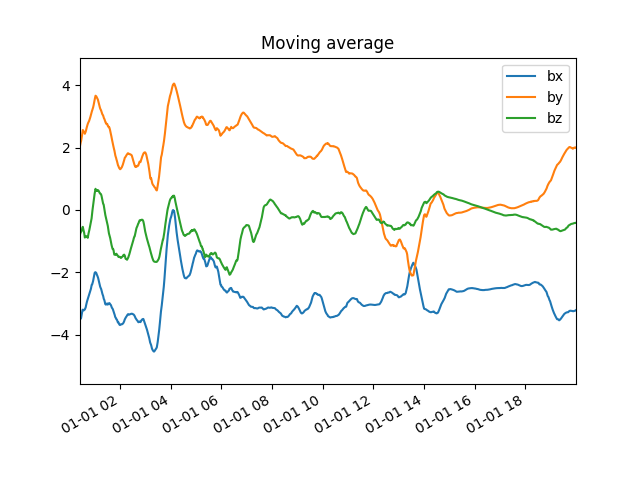

interactive(children=(IntSlider(value=10, description='w', max=1000, min=10), Output()), _dom_classes=('widget…

In [3]:
%matplotlib notebook
def moving_average(x, w=1):
    if len(x.shape)!=1:
        n=x.shape[0]-w+1
        m=x.shape[1]
        a=np.empty((n,m))
        for i in range(m):
            a[:,i]=moving_average(x[:,i],w=w)
        return a
    return np.convolve(x, np.ones(w), 'valid') / w


def ma_plot(x,y,title="Moving average",w_min=1,w_max=100,w_step=1,w_value=10,legend=None):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    lines=ax.plot(x,y)
    plt.title(title)
    if not legend is None:
        plt.legend(legend)
    fig.autofmt_xdate()
    def update_smoothing(w):
        Y=moving_average(y,w)
        t=x[-Y.shape[0]:]
        for i in range(len(lines)):
            lines[i].set_data(t,Y[:,i])
        fig.canvas.draw()
        if isinstance(t,pd.core.series.Series):
            x_m=(t.iloc[0],t.iloc[-1])
        else:
            x_m=(t[0],t[-1])
        plt.xlim(x_m[0],x_m[-1])
    slider=widgets.IntSlider(min=w_min, max=w_max, step=w_step, value=w_value)
    interact(update_smoothing,w=slider)

Y=df["bx"].to_numpy()
X=np.array(range(Y.shape[0]))
labels=["bx","by","bz"]
#ma_plot(df["Time"],df[["bx","by","bz"]], w_min=10, w_max=1000)
ma_plot(df["Time"],df[labels].to_numpy(), w_min=10, w_max=1000,legend=labels)

<IPython.core.display.Javascript object>


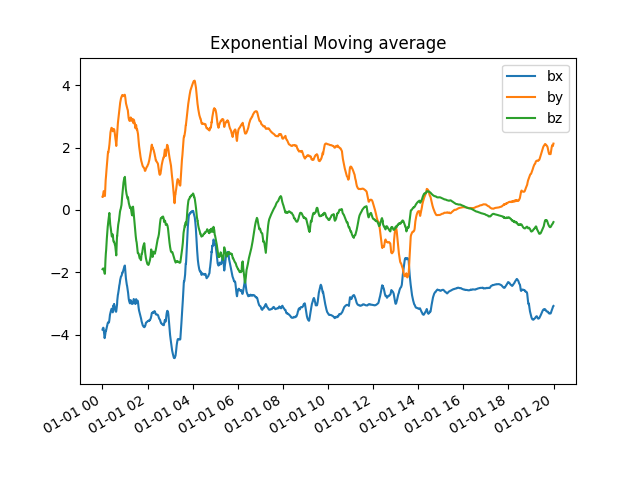

interactive(children=(FloatLogSlider(value=0.9, description='w', max=0.0, min=-10.0, step=0.2), Output()), _do…

In [4]:
def exponential_moving_average(x, w=.9):
    if len(x.shape)!=1:
        n=x.shape[0]
        m=x.shape[1]
        a=np.empty(x.shape)
        for i in range(m):
            a[:,i]=exponential_moving_average(x[:,i],w=w)
        return a
    a=np.empty(x.shape)
    for i in range(a.shape[0]):
        if i==0:
            a[0]=x[0]
        elif np.isnan(x[i]):
            a[i]=a[i-1]
        else:
            a[i]=w*x[i]+(1.-w)*a[i-1]
    return a

def ema_plot(x,y,title="Exponential Moving average",w_min=0.1,w_max=.99,w_value=.9,legend=None):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    lines=ax.plot(x,y)
    plt.title(title)
    if not legend is None:
        plt.legend(legend)
    fig.autofmt_xdate()
    def update_smoothing(w):
        Y=exponential_moving_average(y,w)
        for i in range(len(lines)):
            lines[i].set_ydata(Y[:,i])            
        fig.canvas.draw()
    slider=widgets.FloatLogSlider(value=0.9,base=10,min=-10,max=0,step=0.2)
    interact(update_smoothing,w=slider)
ema_plot(df["Time"],df[labels].to_numpy(),legend=labels)


<IPython.core.display.Javascript object>


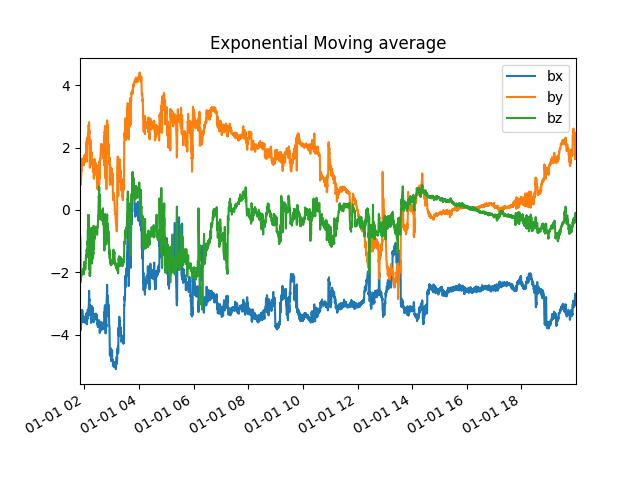

interactive(children=(Checkbox(value=False, description='Grid on'), Output()), _dom_classes=('widget-interact'…

In [5]:
def generic_plot(x,y,title="Exponential Moving average",legend=None):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    lines=ax.plot(x,y)
    plt.title(title)
    if not legend is None:
        plt.legend(legend)
    fig.autofmt_xdate()
    def update_grid(w=False):
        plt.grid(w)
        fig.canvas.draw()
    check=widgets.Checkbox(value=False,description='Grid on',disabled=False)
    interact(update_grid,w=check)
generic_plot(df["Time"],df[labels].to_numpy(),legend=labels)

In [5]:
tree=amdapy.amdaWSClient.client.get_obs_tree()


In [6]:
from lxml.etree import tostring
tree.write("/home/aschulz/obstree.xml",pretty_print=True)
def mission_list():
    l=[]
    for m in tree.iter(tag="mission"):
        l.append(m.get("name"))
    return l
def get_mission(mission_name):
    for m in tree.iter(tag="mission"):
        if m.get("name")==mission_name:
            return m
print(mission_list())

AttributeError: 'ObsTree' object has no attribute 'write'

In [ ]:
def get_mission_datasets(mission_name):
    m_el=get_mission(mission_name)
    l=[]
    for el in m_el.iter(tag="dataset"):
        l.append(get_id(el))
    return l
def get_id(el):
    if not isinstance(el, etree._Element):
        return
    for k in el.attrib:
        if k.endswith("}id"):
            return el.attrib[k]
def get_dataset(dataset_id):
    for d in tree.iter("dataset"):
        if get_id(d)==dataset_id:
            return d
def get_dataset_parameters(dataset_id):
    d_el=get_dataset(dataset_id)
    l=[]
    for e in d_el.iter("parameter"):
        l.append(get_id(e))
    return l
def mission_dataset_dd(mission_name):
    w= widgets.Dropdown(options=get_mission_datasets(mission_name),description="{} datasets:".format(mission_name))
    interact(parameter_dd, dataset_id=w)
def parameter_dd(dataset_id):
    w=widgets.Dropdown(options=get_dataset_parameters(dataset_id),description="{} parameters:".format(dataset_id))
    interact(dataset_plot,parameter_id=w)
def dataset_plot(parameter_id):
    print("dataset plot {}".format(parameter_id))
    
    plt.clf()
    plt.title(parameter_id)
    plt.draw()
fig=plt.figure()
plt.plot(np.random.random_sample(199))
plt.title("")
dropdown=widgets.Dropdown(options=mission_list(),description='Mission:')
interact(mission_dataset_dd, mission_name=dropdown)

In [ ]:
from IPython.display import display
button = widgets.Button(description="Click Me!")
output = widgets.Output()

display(button, output)

def on_button_clicked(b):
    with output:
        print("Button clicked.")

button.on_click(on_button_clicked)

In [ ]:
int_range = widgets.IntSlider()
output2 = widgets.Output()

display(int_range, output2)

def on_value_change(change):
    with output2:
        print(change['new'])

int_range.observe(on_value_change, names='value')



In [ ]:
x_widget = widgets.FloatSlider(min=0.0, max=10.0, step=0.05)
y_widget = widgets.FloatSlider(min=0.5, max=10.0, step=0.05, value=5.0)

def update_x_range(*args):
    x_widget.max = 2.0 * y_widget.value
y_widget.observe(update_x_range, 'value')

def printer(x, y):
    print(x, y)
interact(printer,x=x_widget, y=y_widget);



In [ ]:
a = widgets.IntSlider(description='a')
b = widgets.IntSlider(description='b')
c = widgets.IntSlider(description='c')
def f(a, b, c):
    print('{}*{}*{}={}'.format(a, b, c, a*b*c))

out = widgets.interactive_output(f, {'a': a, 'b': b, 'c': c})

widgets.HBox([widgets.VBox([a, b, c]), out])

In [ ]:
mission_label=widgets.Label("Mission:")
dataset_label=widgets.Label("Dataset:")
parameter_label=widgets.Label("Parameter:")
mission_dd=widgets.Dropdown(options=mission_list())
dataset_dd=widgets.Dropdown(options=[])
parameter_dd=widgets.Dropdown(options=[])
label_vbox=widgets.VBox([mission_label,dataset_label,parameter_label])
dd_vbox=widgets.VBox([mission_dd,dataset_dd,parameter_dd])
hbox=widgets.HBox([label_vbox, dd_vbox])


display(hbox)


In [ ]:
# set up plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_ylim([-4, 4])
ax.grid(True)
 
# generate x values
x = np.linspace(0, 2 * np.pi, 100)
 
 
def my_sine(x, w, amp, phi):
    """
    Return a sine for x with angular frequeny w and amplitude amp.
    """
    return amp*np.sin(w * (x-phi))
 
 
@widgets.interact(w=(0, 10, 1), amp=(0, 4, .1), phi=(0, 2*np.pi+0.01, 0.01))
def update(w = 1.0, amp=1, phi=0):
    """Remove old lines from plot and plot new one"""
    [l.remove() for l in ax.lines]
    ax.plot(x, my_sine(x, w, amp, phi), color='C0')

In [ ]:
from amdapy.amdaWSClient.obstree import ObsTree
o=ObsTree(tree)
import time
for dataset in o.iter_dataset():
    print("getting {} , {} to {}".format(dataset.id,dataset.datastart,dataset.datastop))
    t0=time.time()
    n=client.get_dataset(token,dataset.datastart,dataset.datastop,dataset.id)
    print("downloaded data {} : {} in {}s".format(dataset.id,n, time.time()-t0))

## !é&